In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import beta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict

%matplotlib inline

# Exploration

In [2]:
df = pd.read_csv('../data/digitiser_dataset.csv', index_col=0)
df = df[df['x_questions']==20]
df.head(10)

,feedback,name,question,round,best_of_name,model_id,user_id,x_questions
0,-1,Lio,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
1,-1,Sara,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
2,3,Marilou,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
3,-1,Chloé,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
4,-1,Iluna,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
5,3,Mira,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
6,-1,Zoë,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
7,-1,Helena,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
8,-1,June,3,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
9,3,Léa,3,1,True,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20


In [3]:
views = df['name'].value_counts()
views.head()

Anna     3164
Zoé      3071
Lou      2898
Laura    2897
Elize    2894
Name: name, dtype: int64

In [4]:
clicks = df.loc[df['feedback']==3,'name'].value_counts()
clicks.head()

Anna    1224
Lou     1205
Nora    1203
Lili    1159
Ella    1112
Name: name, dtype: int64

In [5]:
clicks_per_view = clicks / views
name_df = pd.DataFrame({'clicks':clicks, 'views':views, 'clicks_per_view':clicks_per_view})
name_df.sort_values('clicks_per_view', ascending=False).head()

,clicks,clicks_per_view,views
Charlie,1.0,1.000000,1
Minne,2.0,0.666667,3
Annabelle,2.0,0.666667,3
Ella,1112.0,0.555445,2002
Nore,501.0,0.524059,956


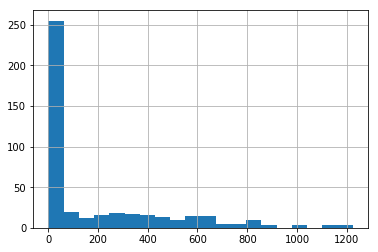

In [6]:
name_df['clicks'].hist(bins=20)

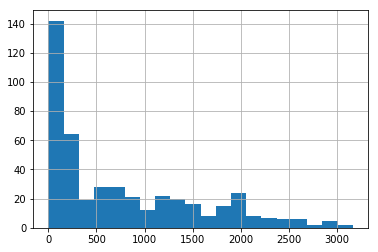

In [7]:
name_df['views'].hist(bins=20)

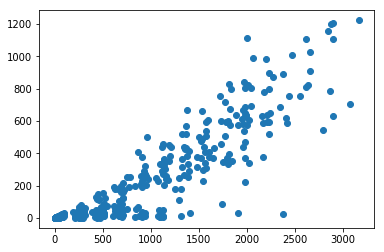

In [8]:
plt.scatter(name_df['views'], name_df['clicks'])

# Bayesian clicks per view

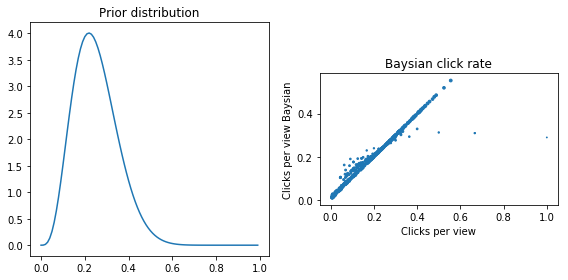

In [9]:
# Get the occurence dataframe
name_df['clicks'] = name_df['clicks'].fillna(0)

# Calcultate parameters of the priors
mu = 0.25
var = 0.06
prior_a = np.power(((1. - mu) / var - 1. / mu) * mu , 2)
prior_b = prior_a * (1. / mu - 1.)

x = np.arange(0, 1, 0.01)
distribution = beta.pdf(x, prior_a, prior_b)

def calculate_baysian_mean(views, clicks):
    non_clicks = views - clicks
    if(views==0): print('no views')
    mean, var, skew, kurt = beta.stats(prior_a + clicks, prior_b + non_clicks, moments='mvsk')
    return mean

# Calculate for each name the baysian clicks per view
name_df['clicks_per_view_baysian'] = name_df.apply(lambda row: calculate_baysian_mean(row['views'], row['clicks']), axis=1)
name_df['clicks_per_view_baysian'] = name_df['clicks_per_view_baysian'].astype(float)

# Some plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

axes[0].plot(x, distribution)
axes[0].set_title('Prior distribution')

axes[1].scatter(name_df['clicks_per_view'], name_df['clicks_per_view_baysian'], s=np.log(name_df['views']+1))
axes[1].set_title('Baysian click rate')
axes[1].set_xlabel('Clicks per view')
axes[1].set_ylabel('Clicks per view Baysian')
axes[1].set_aspect('equal')

fig.tight_layout()



# Baseline


In [10]:
popularity = pd.read_csv('../data/popularity.csv')
popularity.head()

,name,sex,region,year_1995,year_1996,year_1997,year_1998,year_1999,year_2000,year_2001,...,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,Aagje,F,Vlaanderen,0.0,10.0,7.0,6.0,5.0,0.0,12.0,...,10.0,11.0,12.0,11.0,8.0,11.0,7.0,0.0,0.0,0.0
1,Aaliyah,F,Vlaanderen,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,8.0,7.0,14.0,9.0,9.0,7.0,10.0,11.0,8.0,13.0
2,Abigail,F,Vlaanderen,0.0,0.0,8.0,0.0,0.0,0.0,5.0,...,0.0,6.0,7.0,8.0,16.0,11.0,10.0,10.0,11.0,12.0
3,Ada,F,Vlaanderen,0.0,0.0,0.0,0.0,5.0,0.0,6.0,...,12.0,19.0,17.0,20.0,24.0,19.0,28.0,32.0,35.0,27.0
4,Adeline,F,Vlaanderen,15.0,10.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,6.0,8.0,0.0,8.0,0.0,12.0


In [11]:
df['question_id'] = df['model_id'] + '_' + df['question'].astype(str)
df['question_id'].head(12)

0     3dxqYZDIqnnbnJRwd9xF_1
1     3dxqYZDIqnnbnJRwd9xF_1
2     3dxqYZDIqnnbnJRwd9xF_1
3     3dxqYZDIqnnbnJRwd9xF_1
4     3dxqYZDIqnnbnJRwd9xF_2
5     3dxqYZDIqnnbnJRwd9xF_2
6     3dxqYZDIqnnbnJRwd9xF_2
7     3dxqYZDIqnnbnJRwd9xF_2
8     3dxqYZDIqnnbnJRwd9xF_3
9     3dxqYZDIqnnbnJRwd9xF_3
10    3dxqYZDIqnnbnJRwd9xF_3
11    3dxqYZDIqnnbnJRwd9xF_3
Name: question_id, dtype: object

In [12]:
most_popular = (
    pd.merge(
        df, 
        popularity, 
        left_on = 'name', 
        right_on = 'name')
     .sort_values('year_2016', ascending=False)
     .groupby('question_id')['name'].first())
clicked = df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()

In [13]:
most_popular.head()

question_id
00329XrhSh1vtc7swjcP_1     Lucie
00329XrhSh1vtc7swjcP_11    Emily
00329XrhSh1vtc7swjcP_12     Lore
00329XrhSh1vtc7swjcP_13     Emma
00329XrhSh1vtc7swjcP_14     Ella
Name: name, dtype: object

In [14]:
clicked.head()

question_id
00329XrhSh1vtc7swjcP_1        Mona
00329XrhSh1vtc7swjcP_11    Paulien
00329XrhSh1vtc7swjcP_12       Maya
00329XrhSh1vtc7swjcP_13    Phaedra
00329XrhSh1vtc7swjcP_14        Zoé
Name: name, dtype: object

In [15]:
questions = pd.DataFrame({'most_popular':most_popular, 'clicked':clicked})
questions.head()

,clicked,most_popular
question_id,,
00329XrhSh1vtc7swjcP_1,Mona,Lucie
00329XrhSh1vtc7swjcP_11,Paulien,Emily
00329XrhSh1vtc7swjcP_12,Maya,Lore
00329XrhSh1vtc7swjcP_13,Phaedra,Emma
00329XrhSh1vtc7swjcP_14,Zoé,Ella


In [16]:
(questions['clicked'] == questions['most_popular']).mean()

0.36012228260869567

The popularity based recommender guesses clicks correctly **36%** of the time

# Content-based recommender

## Modeling for a single user

In [17]:
feature_df = pd.read_csv('../data/features.csv', index_col=0)

In [18]:
df['target'] = df['feedback'].map({-1:0, 3:1})

In [19]:
model_id = df['model_id'].sample().iloc[0]
model_df = pd.merge(df[df['model_id']==model_id], feature_df, on='name')
model_df.head(12)

,feedback,name,question,round,best_of_name,model_id,user_id,x_questions,question_id,target,...,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,-1,Lara,1,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_1,0,...,145.0,111.0,91.0,110.0,90.0,105.0,86.0,99.0,85.0,88.0
1,3,Lili,1,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_1,1,...,30.0,25.0,38.0,34.0,43.0,46.0,43.0,55.0,34.0,31.0
2,-1,Victoria,1,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_1,0,...,41.0,36.0,43.0,52.0,58.0,60.0,75.0,59.0,52.0,56.0
3,-1,Annabel,1,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_1,0,...,19.0,24.0,26.0,19.0,38.0,22.0,31.0,34.0,23.0,28.0
4,3,Elise,2,1,True,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_2,1,...,260.0,296.0,323.0,317.0,313.0,318.0,341.0,351.0,317.0,308.0
5,-1,Chaimae,2,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_2,0,...,15.0,10.0,9.0,12.0,7.0,0.0,8.0,0.0,0.0,0.0
6,-1,Nell,2,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_2,0,...,25.0,22.0,17.0,27.0,30.0,39.0,43.0,53.0,60.0,47.0
7,-1,Liv,2,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_2,0,...,45.0,38.0,47.0,69.0,84.0,107.0,108.0,119.0,163.0,168.0
8,3,Martha,3,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_3,1,...,15.0,18.0,16.0,25.0,35.0,38.0,35.0,41.0,36.0,36.0
9,-1,Laure,3,1,False,c7z7Wj5hEiKDC3Rc4o8Y,Xj9I4oOb8y8QJU87CKNc,20,c7z7Wj5hEiKDC3Rc4o8Y_3,0,...,88.0,84.0,76.0,90.0,69.0,96.0,78.0,84.0,79.0,87.0


In [20]:
features = ['score_classic', 'dtw_vlaanderen_1',
       'dtw_vlaanderen_2', 'score_typical_vl', 'score_typical_wal',
       'score_typical_bxl']

In [21]:
X = model_df[features]
y = model_df['target']

In [22]:
clf = RandomForestClassifier()

In [23]:
param_grid = {'n_estimators':[200], 'max_depth':[3]}
clf_gs = GridSearchCV(clf,param_grid=param_grid, cv=4, n_jobs=-1)
clf_gs.fit(X,y)
clf_gs.best_params_

{'max_depth': 3, 'n_estimators': 200}

## Find top 30

In [24]:
X_other = feature_df.loc[~feature_df['name'].isin(model_df['name']), features]
name_other = feature_df.loc[~feature_df['name'].isin(model_df['name']), 'name']

In [25]:
best_clf = clf_gs.best_estimator_
y_other = best_clf.predict_proba(X_other)[:,1]

In [26]:
results = pd.DataFrame({'name':name_other, 'score':y_other})

In [27]:
results.sort_values('score', ascending=False)['name'].head(30)

536         Julie
950          Sara
414        Helena
600         Laura
24          Aline
733         Manon
74           Anna
800      Michelle
786       Melanie
624         Leona
793         Merel
21          Alice
286        Emilie
979          Sien
102        Astrid
884       Paulien
311        Esther
165        Celine
243         Edith
1049         Vera
44          Amber
428           Ida
232          Dina
1017       Sylvia
253         Elien
1005    Stephanie
614          Lena
1014      Suzanne
906         Renée
547          Kaat
Name: name, dtype: object

## Estimate model performance

In [28]:
cv_score = cross_val_predict(best_clf,X,y, cv=8,n_jobs=-1, method='predict_proba')[:,1]

In [29]:
model_df['cv_score'] = cv_score

In [30]:
%time best_score = (model_df.sort_values('cv_score', ascending=False).groupby('question_id')['name'].first())
%time clicked = model_df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()

CPU times: user 5.39 ms, sys: 2.73 ms, total: 8.13 ms
Wall time: 6.47 ms
CPU times: user 3.99 ms, sys: 568 µs, total: 4.56 ms
Wall time: 4.13 ms


In [31]:
questions = pd.DataFrame({'best_score':best_score, 'clicked':clicked})
questions

,best_score,clicked
question_id,,
c7z7Wj5hEiKDC3Rc4o8Y_1,Lara,Lili
c7z7Wj5hEiKDC3Rc4o8Y_11,Nora,Nora
c7z7Wj5hEiKDC3Rc4o8Y_12,Emma,Emma
c7z7Wj5hEiKDC3Rc4o8Y_13,Marie,Lize
c7z7Wj5hEiKDC3Rc4o8Y_14,Lea,Floor
c7z7Wj5hEiKDC3Rc4o8Y_16,Hannah,Hannah
c7z7Wj5hEiKDC3Rc4o8Y_17,Chloé,Chloé
c7z7Wj5hEiKDC3Rc4o8Y_18,Josephine,Josephine
c7z7Wj5hEiKDC3Rc4o8Y_19,Fien,Elisa


In [32]:
(questions['clicked'] == questions['best_score']).mean()

0.5

## Estimate performance on many users

In [33]:
correctness = {}
for model_id in df['model_id'].drop_duplicates().sample(50):
    model_df = pd.merge(df[df['model_id']==model_id], feature_df, on='name', how='inner')
    X = model_df[features]
    y = model_df['target']
    #clf_gs.fit(X,y)
    cv_score = cross_val_predict(best_clf,X,y, cv=3, method='predict_proba', n_jobs=-1)[:,1]
    model_df['cv_score'] = cv_score
    best_score = (model_df.sort_values('cv_score', ascending=False).groupby('question_id')['name'].first())
    clicked = model_df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()
    questions = pd.DataFrame({'best_score':best_score, 'clicked':clicked})
    correctness[model_id] = (questions['clicked'] == questions['best_score']).mean()
correctness = pd.Series(correctness)

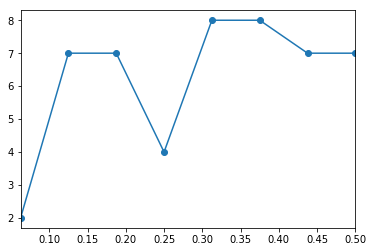

In [35]:
pd.Series(correctness).value_counts().sort_index().plot(marker='o')

In [36]:
correctness.mean()

0.3075